In [121]:
import pandas as pd
import networkx as nx 
import glob
import numpy as np
from scipy.linalg import fractional_matrix_power
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
from matplotlib import pyplot as plt

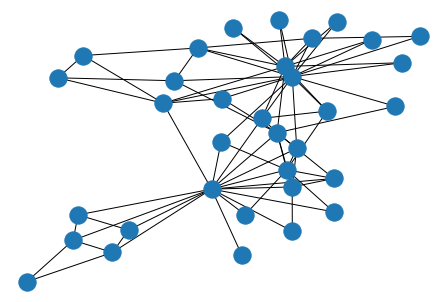

In [122]:
def return_graph(filename): 
    df = pd.read_csv(filename, header=None)
    return nx.from_numpy_matrix(df.values)
nx.draw(return_graph('D1-K=2.csv'), pos=nx.spring_layout(return_graph('D1-K=2.csv')))

In [128]:
from sklearn.metrics import calinski_harabasz_score
import tqdm

In [166]:
def cluster_graph(G, n_clusters=None): 
    am = nx.adjacency_matrix(G)
    D = np.diag([G.degree()[i] for i in range(len(G.nodes))])
    L = D - am 
    D_1_2 = fractional_matrix_power(D, -0.5)
    NL = D_1_2 @ L @ D_1_2
    eigenvalues, eigenvectors = np.linalg.eig(NL)
    eigenvalues_abs = np.abs(eigenvalues)
    sort_indices = np.argsort(eigenvalues_abs)
    n_indices = max(1, len(G.nodes)//5) if n_clusters is None else n_clusters
    #n_indices = 1
    chosen_indices = sort_indices[:n_indices]
    chosen_vectors = eigenvectors[:, chosen_indices]
    components = NL.T @chosen_vectors
    if n_clusters is None: 
        scores = []
        for i in tqdm.tqdm(range(2, len(G.nodes)//10)):
            clusters = KMeans(n_clusters=i).fit_predict(components)
            scores.append(calinski_harabasz_score(components, clusters))
        n_clusters = np.argmax(scores) + 2 
        
    return AgglomerativeClustering(n_clusters=n_clusters).fit_predict(components)
clusters = cluster_graph(return_graph('D3-UNC.csv'), None)


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 56.16it/s]


In [167]:
def draw_clusters(G, clusters, ax): 
    nx.draw(G, cmap=plt.get_cmap('viridis'), node_color=clusters, ax=ax,
           pos=nx.spring_layout(G))


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:00<00:00, 62.50it/s]

D1-K=2.csv
D1-UNC.csv


  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

D2-K=7.csv
D2-UNC.csv


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

D3-K=12.csv
D3-UNC.csv


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 55.55it/s]


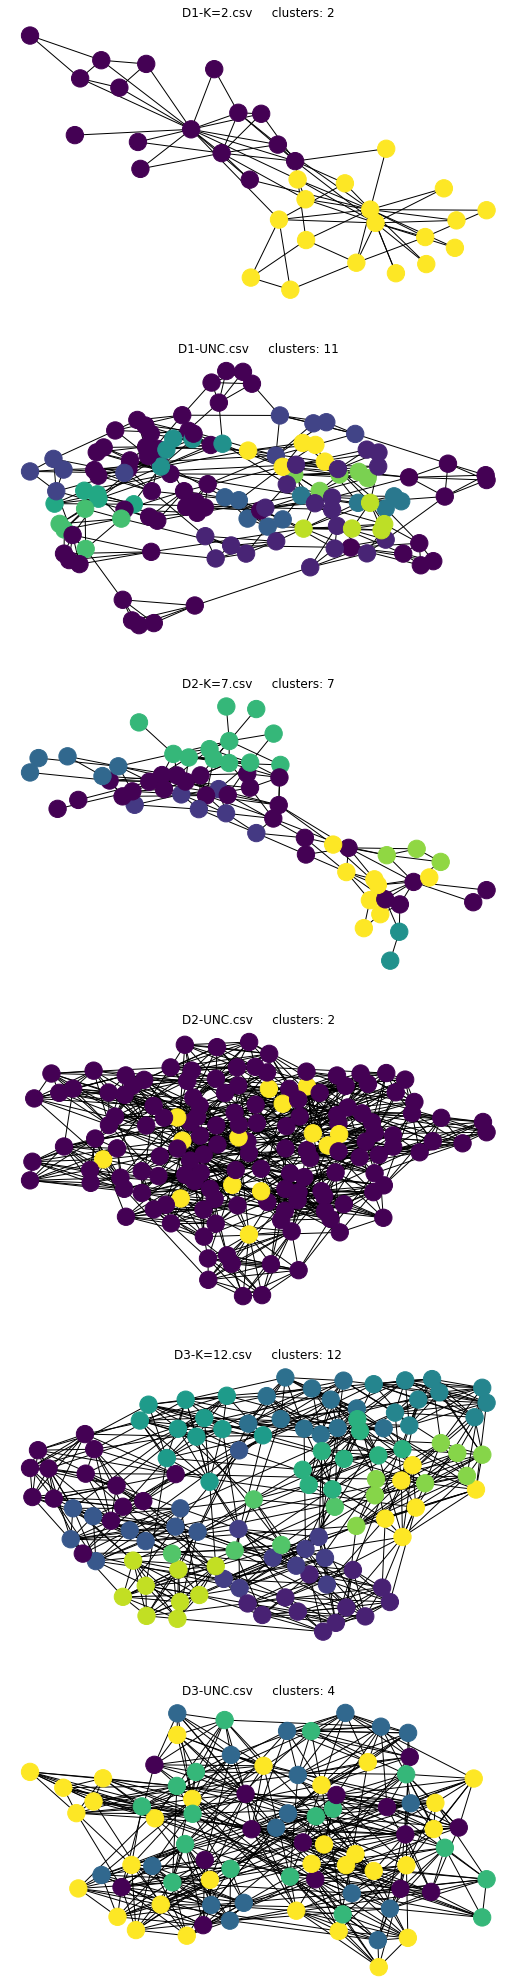

In [168]:
files = glob.glob('D*csv')
fig, axs = plt.subplots(nrows=len(files), figsize=(9, 6*len(files)))
for i, file in enumerate(files): 
    print(file)
    if 'K' in file:
        idx = file.index('=')
        n_clusters = int(file.replace('.csv', '')[idx+1:])
    else: 
        n_clusters = None
    G = return_graph(file)
    clusters = cluster_graph(G, n_clusters=n_clusters)
    draw_clusters(G, clusters, ax=axs[i])
    axs[i].set_title(file + f'     clusters: {len(set(clusters))}')